In [75]:
import os
import sys
import json
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
warnings.filterwarnings('ignore')

pplt.rc.update({
    'reso':'xx-hi',
    'font.size':10,
    'figure.dpi':100,
    'figure.facecolor':'black',
    'savefig.facecolor':'black',
    'axes.facecolor':'white',
    'axes.edgecolor':'white',
    'axes.labelcolor':'white',
    'tick.color':'white',
    'tick.labelcolor':'white',
    'title.color':'white',
    'colorbar.edgecolor':'white'})

In [76]:
with open('/global/cfs/cdirs/m4334/sferrett/monsoon-kernels/scripts/configs.json','r',encoding='utf-8') as f:
    CONFIGS = json.load(f)
SPLITSDIR  = CONFIGS['filepaths']['splits']    
MODELSDIR  = CONFIGS['filepaths']['models']
PREDSDIR   = CONFIGS['filepaths']['predictions']
MODELS     = CONFIGS['models']
SPLIT      = 'valid'   

In [77]:
with xr.open_dataset(os.path.join(SPLITSDIR,f'{SPLIT}.h5'),engine='h5netcdf') as ds:
    truepr = ds.pr.load()

results = {}
for model in MODELS:
    name,description = model['name'],model['description']
    filename = f'{name}_{SPLIT}_predictions.nc'
    filepath = os.path.join(PREDSDIR,filename)
    if os.path.exists(filepath):
        with xr.open_dataset(filepath,engine='h5netcdf') as ds:
            predpr = ds.pr.load()
        ytrue,ypred = xr.align(truepr,predpr,join='inner')
        results[name] = dict(description=description,ytrue=ytrue,ypred=ypred)
print(f'Found {len(results)} completed models for `{SPLIT}`')

nrows = 2
ncols = 4

Found 5 completed models for `valid`


In [78]:
def get_r2(ytrue,ypred,dims=None,landfrac=None,landthresh=0.5):
    dims = list(ytrue.dims) if dims is None else dims
    if landfrac is not None:
        r2values = []
        for mask in [landfrac>=landthresh,landfrac<landthresh]:
            ssres = ((ytrue.where(mask)-ypred.where(mask))**2).sum(dim=dims,skipna=True)
            sstot = ((ytrue.where(mask)-ytrue.where(mask).mean(dim=dims,skipna=True))**2).sum(dim=dims,skipna=True)
            r2values.append(1-ssres/sstot)
        return tuple(r2values)
    ssres = ((ytrue-ypred)**2).sum(dim=dims,skipna=True)
    sstot = ((ytrue-ytrue.mean(dim=dims,skipna=True))**2).sum(dim=dims,skipna=True)
    return 1-ssres/sstot

In [86]:
def plot_r2_bars(results):
    labels,r2s = [],[]
    for runname,result in results.items():
        # otheritems = [(runname,result) for runname,result in results.items() if runname=='baseline_full' or 'vertical' in runname]
        description = result['description']
        ytrue,ypred = result['ytrue'],result['ypred']
        r2 = get_r2(ytrue,ypred,dims=None)
        labels.append(description)
        r2s.append(r2)
    fig,ax = pplt.subplots(nrows=1,ncols=1,refwidth=4,refheight=2)
    ax.format(xlabel='Validation Set R$^2$',ylabel='',grid=False)
    ax.barh(labels,r2s,color='#084f6a',capsize=3)
    pplt.show()
    fig.save('../figs/agu_baseline.jpg',bbox_inches='tight')

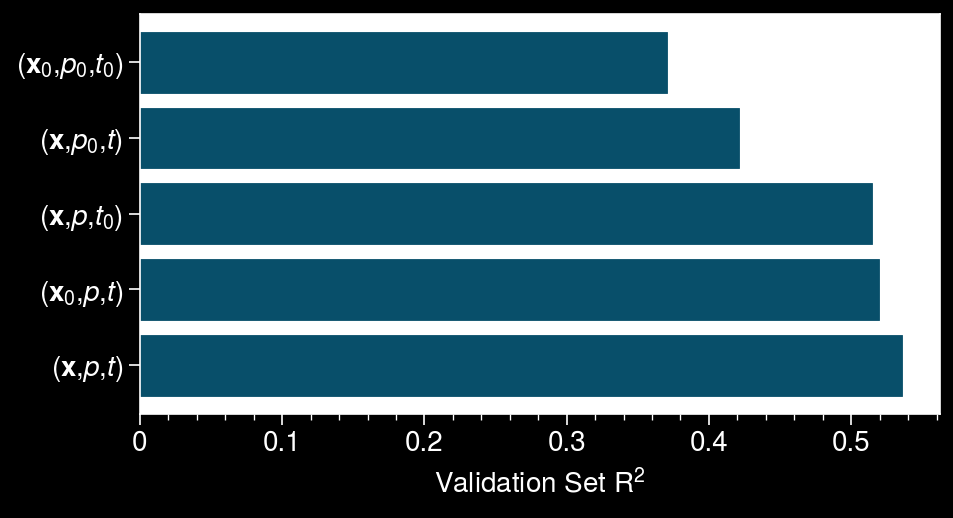

In [87]:
plot_r2_bars(results)